In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10, 25, 50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за период в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 балла). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 балла). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы берете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 балла).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


### Решение

### Изучение данных и метрик

In [162]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [163]:
df.head()

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160


In [20]:
len(df)

8625842

In [108]:
# имеем 3 сегмента
len(df.user_segment.unique())

3

In [105]:
# имеем 33 категории
len(df.category.unique())

33

In [109]:
# имеем 84 региона
len(df.region.unique())

84

**Статистика метрики (revenue_amount)**

Изучим основные статистики для метрики выручки:

In [73]:
df.revenue_amount.describe().round(decimals=1)

count    8625842.0
mean         400.9
std          960.2
min            1.0
25%           88.0
50%          167.0
75%          405.0
max       288123.0
Name: revenue_amount, dtype: float64

Видим, что разброс достаточно велик. Среднее сильно отличается от медианы, что говорит о большом количестве выбросов. На это указывает и максимальное значение (288123) - скорее всего сегмент крупных пользователей.

**Статистики внутри срезов**

Рассмотрим статистики внутри срезов: 
- по сегментам пользователей - *user_segment*;
- по категориям - *category*;
- по регионам - *region*.

Начнем с сегментов:

In [82]:
d_mean = df.groupby('user_segment', as_index=False).mean()
d_std = df.groupby('user_segment', as_index=False).std()

In [83]:
df_user_segment = pd.DataFrame()
df_user_segment[['user_segment', 'revenue_amount_mean']] = d_mean.loc[:, ['user_segment', 'revenue_amount']]
df_user_segment['revenue_amount_std'] = d_std.loc[:, 'revenue_amount']
df_user_segment

,user_segment,revenue_amount_mean,revenue_amount_std
0,853431062533847667,1094.330305,2392.330098
1,2376074197230840906,401.615956,571.446013
2,4626944681007198896,207.760172,285.545686


Видим 3 сегмента, отличающихся по суммам покупок - крупные (mean=1094), средние (mean=402) и мелкие (mean=208). У "небольших" пользователей разброс их покупок не так уж велик, а больших пользователей и разброс большой, но их не так много. Это может помочь снизить дисперсию при использовании подхода стратификации. 

Рассмотрим категории:

In [90]:
d_mean = df.groupby('category', as_index=False).mean()
d_std = df.groupby('category', as_index=False).std()

In [96]:
df_category = pd.DataFrame()
df_category[['category', 'revenue_amount_mean']] = d_mean.loc[:, ['category', 'revenue_amount']]
df_category['revenue_amount_std'] = d_std.loc[:, 'revenue_amount']
df_category.head()

,category,revenue_amount_mean,revenue_amount_std
0,57514010642945023,347.826167,605.864274
1,91460430793700892,441.861699,651.938097
2,174490086998335078,325.149759,764.813512
3,264558924403680107,509.373364,747.222091
4,282115902545472456,260.778575,354.734991


In [97]:
df_category[['revenue_amount_mean', 'revenue_amount_std']].describe()

,revenue_amount_mean,revenue_amount_std
count,33.000000,33.000000
mean,427.308587,778.739216
std,336.174781,657.301011
min,136.595029,172.984799
25%,233.014721,354.734991
50%,352.174948,605.864274
75%,497.431001,790.312625
max,1955.979431,3164.815179


Видим, что категорий гораздо больше, чем сегментов и большинство из них не слишком сильно отличаются по суммам покупок (в среднем около 400), но разброс в них достаточно большой -> стратификация вряд ли поможет снизить дисперсию.

Перейдем к регионам

In [102]:
d_mean = df.groupby('region', as_index=False).mean()
d_std = df.groupby('region', as_index=False).std()

In [103]:
df_region = pd.DataFrame()
df_region[['region', 'revenue_amount_mean']] = d_mean.loc[:, ['region', 'revenue_amount']]
df_region['revenue_amount_std'] = d_std.loc[:, 'revenue_amount']
df_region.head()

,region,revenue_amount_mean,revenue_amount_std
0,68475388295793322,289.345317,504.681673
1,181387893390186210,299.629748,461.930430
2,308194675497345788,252.626919,544.986118
3,385667469633138042,272.589534,507.917500
4,405364780634206711,205.209615,295.197711


In [104]:
df_region[['revenue_amount_mean', 'revenue_amount_std']].describe()

,revenue_amount_mean,revenue_amount_std
count,84.000000,84.000000
mean,299.283940,538.972712
std,94.141554,274.794660
min,182.157253,222.724661
25%,237.126174,373.902375
50%,282.286679,487.580936
75%,336.866921,621.041145
max,709.130762,1819.635279


Видим, что регионы почти не отличаются по среднему числу покупок и обладают малым разбросом (относительно других срезов).

### MDE

Предскажем минимально детектируемый эффект (MDE) для различных размеров групп и длительности эксперимента:

In [64]:
def calculate_mde(mean, std, alpha, power, n):
    effects = np.linspace(0.5, 0.001, num=1000)
    volums = []
    for i, effect in enumerate(effects):
        effect_size = (mean/std) * effect
        volums.append(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')/n)
        if  volums[i] <= 1:
            mde = effect
    return mde, effects, volums

In [135]:
# определеим минимальную дату - она будет началом эксперимента
print(df.event_date.min())

2019-06-18 00:00:00


In [327]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

Установим размер тестовой группы на уровне 10% и будем варьировать длительность эксперимента (30, 60 и 90 дней):

In [328]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.1) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.12787287287287286

In [329]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 60, 0.1) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.12637437437437438

In [330]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 90, 0.1) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.12287787787787785

Таким образом, видим, что длительность эксперимента значительно не влияет на MDE, а сам MDE слишком уж велик - нужно увеличивать размер тестовой группы.

Увеличим размер тестовой группы до 25%:

In [332]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.25) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.09340740740740738

In [333]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 60, 0.25) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.09041041041041037

In [334]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 90, 0.25) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.08991091091091091

Увеличим размер тестовой группы до 50%:

In [476]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.05894194194194191

In [477]:
std

6761.943172332689

In [336]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 60, 0.5) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.05744344344344343

In [337]:
x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 90, 0.5) #получаем необходимую подвыборку
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.05744344344344343

Таким образом, видим, что не смотря на задействование максимального количества ресурсов (по продолжительности и размеру выборок), MDE остается достаточноо большим (6% - многовато для выручки, должно быть сильное изменение продукта для такого роста/падения) -> нужно снижать дисперсию.

### Снижение дисперсии (CUPED)

Так как имеем достаточно много исторических данных, то можем воспользоваться подходом CUPED для снижения дисперсии -> увеличения чувтсвительности наших тестов.

In [6]:
def choose_pre_period(data, start_date, delta, users): 
    tmp = data[
        (data.event_date>=start_date)&
        (data.event_date<=start_date+datetime.timedelta(days=delta))&
        (data.user_id.isin(users))
    ]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    return tmp

Возьмем первый возможный период для начала теста - 30 дней спустя минимальной даты (эти 30 дней будут предпериодом):

In [41]:
x = choose_date(df, datetime.datetime(2019, 7, 18, 0, 0), 30, 0.5) #получаем необходимую подвыборку

In [42]:
x_pre_period = choose_pre_period(df, datetime.datetime(2019, 6, 18, 0, 0), 30, users=x.user_id)
x_pre_period.head()

,user_id,user_segment,category,region,revenue_amount
0,277934167554935,2.851289e+19,8.645705e+19,3.301742e+19,4832.0
1,303610674901026,7.128223e+18,1.725420e+17,1.156743e+19,772.0
2,333739223557249,9.253889e+18,2.944463e+18,6.874165e+18,126.0
3,374386813024644,9.253889e+18,1.013046e+19,2.093354e+18,185.0
4,460080492411737,9.253889e+18,1.196665e+19,9.396608e+18,180.0


In [43]:
x_merged = x.merge(x_pre_period[['user_id', 'revenue_amount']], how='left', on='user_id')
x_merged['revenue_amount_y'].fillna(0, inplace=True)
x_merged.rename(columns={'revenue_amount_x': 'revenue_amount', 'revenue_amount_y': 'pre_revenue_amount'}, inplace=True)
x_merged.head()

,index,user_id,user_segment,category,region,revenue_amount,pre_revenue_amount
0,0,702221222224,4.626945e+18,6.742558e+18,2.201389e+18,356.0,0.0
1,6,73834573097944,9.253889e+18,6.813584e+18,2.232932e+18,2392.0,0.0
2,8,87029396555710,4.626945e+18,1.560592e+18,6.847539e+16,111.0,0.0
3,9,88433173713624,4.752148e+18,3.489802e+17,6.826400e+18,68.0,0.0
4,10,111281855931038,4.626945e+18,6.742558e+18,5.780544e+18,139.0,0.0


Считаем среднее предпериода:

In [44]:
x_merged['pre_revenue_average']=x_merged.pre_revenue_amount.mean() 

Считаем множитель для CUPED:

In [45]:
x_merged.revenue_amount.shape

(305297,)

In [46]:
x_merged.pre_revenue_amount.shape

(305297,)

In [47]:
teta = np.cov(x_merged.revenue_amount, x_merged.pre_revenue_amount, ddof=1)[1,0]/np.var(x_merged.pre_revenue_amount, ddof=1)

In [48]:
corr = np.corrcoef(x_merged.revenue_amount, x_merged.pre_revenue_amount)[1,0] 

Считаем CUPED-метрику:

In [49]:
x_merged['cuped_revenue_amount'] = x_merged.revenue_amount - teta * (x_merged.pre_revenue_amount - x_merged.pre_revenue_average)

In [50]:
x_merged.head()

,index,user_id,user_segment,category,region,revenue_amount,pre_revenue_amount,pre_revenue_average,cuped_revenue_amount
0,0,702221222224,4.626945e+18,6.742558e+18,2.201389e+18,356.0,0.0,802.732022,1040.73624
1,6,73834573097944,9.253889e+18,6.813584e+18,2.232932e+18,2392.0,0.0,802.732022,3076.73624
2,8,87029396555710,4.626945e+18,1.560592e+18,6.847539e+16,111.0,0.0,802.732022,795.73624
3,9,88433173713624,4.752148e+18,3.489802e+17,6.826400e+18,68.0,0.0,802.732022,752.73624
4,10,111281855931038,4.626945e+18,6.742558e+18,5.780544e+18,139.0,0.0,802.732022,823.73624


Считаем MDE для CUPED-метрики:

In [51]:
mean = x_merged.cuped_revenue_amount.mean()
std = x_merged.cuped_revenue_amount.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x_merged.shape[0])
mde

0.03396696696696694

Таким образом, уже сейчас видим значительное снижение MDE.

#### Проверка сезональности 

Проверим насколько данный подход (CUPED) подвержен сезональности -> посмотрим как меняется MDE, если применять его в другие периоды и определим "cамый минимальный" MDE:

In [18]:
df.event_date.max()

Timestamp('2019-12-09 00:00:00')

В качестве шага будем использовать недели (кажется, что короче нет смысла):

In [57]:
cur = datetime.datetime(2019, 7, 19, 0, 0)
max_date = datetime.datetime(2019, 12, 9, 0, 0)
counter = 0
while cur <= max_date - datetime.timedelta(days=30):
    cur += datetime.timedelta(days=7)
    counter += 1
print('Количество подходящих для эксперимента полных недель:', counter)

Количество подходящих для эксперимента полных недель: 17


In [52]:
def predict_mde(data, date, delta, share):
    x = choose_date(data, date, delta, share) #получаем необходимую подвыборку
    x_pre_period = choose_pre_period(data, date - datetime.timedelta(days=30), 30, users=x.user_id)
    x_merged = x.merge(x_pre_period[['user_id', 'revenue_amount']], how='left', on='user_id')
    x_merged['revenue_amount_y'].fillna(0, inplace=True)
    x_merged.rename(columns={'revenue_amount_x': 'revenue_amount', 'revenue_amount_y': 'pre_revenue_amount'}, inplace=True)
    x_merged['pre_revenue_average']=x_merged.pre_revenue_amount.mean() 
    teta = np.cov(x_merged.revenue_amount, x_merged.pre_revenue_amount, ddof=1)[1,0]/np.var(x_merged.pre_revenue_amount, ddof=1)
    corr = np.corrcoef(x_merged.revenue_amount, x_merged.pre_revenue_amount)[1,0] 
    x_merged['cuped_revenue_amount'] = x_merged.revenue_amount - teta * (x_merged.pre_revenue_amount - x_merged.pre_revenue_average)

    mean = x_merged.cuped_revenue_amount.mean()
    std = x_merged.cuped_revenue_amount.std()
    alpha = 0.01
    power = 0.8
    mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x_merged.shape[0])
    return mde

In [71]:
MDE = []
dates = []
min_date = datetime.datetime(2019, 7, 19, 0, 0)
min_mde = 1
for i in range(17):
    cur_date = datetime.datetime(2019, 7, 19, 0, 0) + datetime.timedelta(days=7*i)
    cur_mde = predict_mde(df, cur_date, 30, 0.5)
    MDE.append(cur_mde)
    if cur_mde < min_mde:
        min_mde = cur_mde
        min_date = cur_date
    dates.append(cur_date)

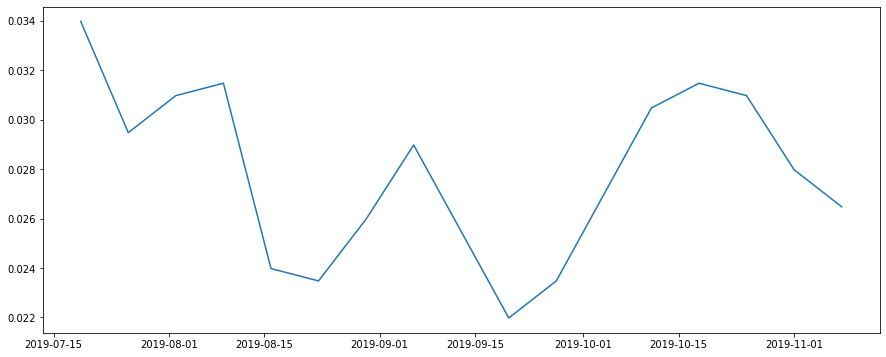

In [72]:
fig = plt.figure(figsize=(15, 6))
plt.plot(dates, MDE)

In [73]:
print(min_mde, min_date)

0.021978978978978936 2019-09-20 00:00:00


Таким образом, видим, что MDE подвержен изменению в зависимости от начала эксперимента (сезональности). Наименьший MDE получился на уровне 2.2% (более чем в 2 раза снизили исходный).

**Оптимизация подхода путем варьирования количества дней до теста**

Попробуем выбрать другой препериод (будем отдаляться от исходного с шагом в 1 день). Посмотрим, сможем ли еще сильнее снизить полученный MDE (2.2%).

In [80]:
def predict_mde_with_shift(data, date, delta, share, shift):
    x = choose_date(data, date, delta, share) #получаем необходимую подвыборку
    x_pre_period = choose_pre_period(data, date - datetime.timedelta(days=30+shift), 30, users=x.user_id)
    x_merged = x.merge(x_pre_period[['user_id', 'revenue_amount']], how='left', on='user_id')
    x_merged['revenue_amount_y'].fillna(0, inplace=True)
    x_merged.rename(columns={'revenue_amount_x': 'revenue_amount', 'revenue_amount_y': 'pre_revenue_amount'}, inplace=True)
    x_merged['pre_revenue_average']=x_merged.pre_revenue_amount.mean() 
    teta = np.cov(x_merged.revenue_amount, x_merged.pre_revenue_amount, ddof=1)[1,0]/np.var(x_merged.pre_revenue_amount, ddof=1)
    corr = np.corrcoef(x_merged.revenue_amount, x_merged.pre_revenue_amount)[1,0] 
    x_merged['cuped_revenue_amount'] = x_merged.revenue_amount - teta * (x_merged.pre_revenue_amount - x_merged.pre_revenue_average)

    mean = x_merged.cuped_revenue_amount.mean()
    std = x_merged.cuped_revenue_amount.std()
    alpha = 0.01
    power = 0.8
    mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x_merged.shape[0])
    return mde

In [10]:
cur = datetime.datetime(2019, 9, 20, 0, 0) - datetime.timedelta(days=30)
minimal_date = datetime.datetime(2019, 7, 19, 0, 0)
counter = 0
while cur > minimal_date:
    cur -= datetime.timedelta(days=1)
    counter += 1
print('Количество подходящих для эксперимента дней:', counter)

Количество подходящих для эксперимента дней: 33


In [90]:
MDE = []
dates = []
min_date = datetime.datetime(2019, 9, 20, 0, 0) - datetime.timedelta(days=30)
min_mde = 1
for i in range(33):
    cur_date = datetime.datetime(2019, 9, 20, 0, 0) - datetime.timedelta(days=30+i)
    cur_mde = predict_mde_with_shift(df, cur_date, 30, 0.5, i)
    MDE.append(cur_mde)
    if cur_mde < min_mde:
        min_mde = cur_mde
        min_date = cur_date
    dates.append(cur_date)

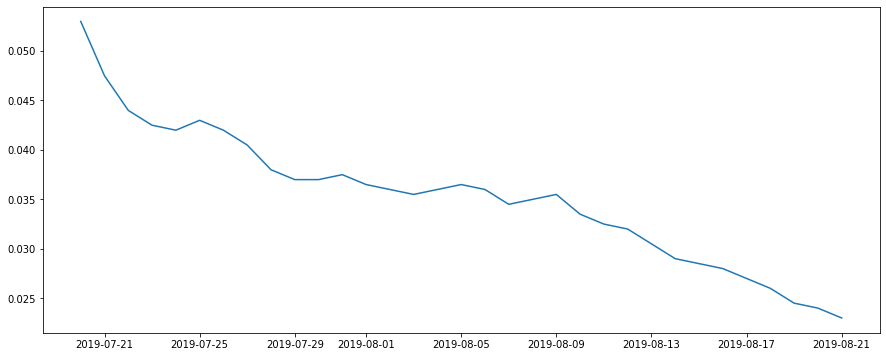

In [91]:
fig = plt.figure(figsize=(15, 6))
plt.plot(dates, MDE)

In [92]:
print(min_mde, min_date)

0.02297797797797796 2019-08-21 00:00:00


Видим, что MDE снижается при приближении предпериода к экспериментальному -> еще больше снизить MDE не удалось.

### Стратификация

Попробуем другой подход - стратификацию.  
Начнем с пользовательских сегментов (*user_segment*):

In [479]:
def choose_date_for_strat(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

В данных обнаружились пользователи, которые относятся к разным сегментам (нарушается условие для применения стратификации). Пойдем на упрощение - назначим каждому пользователю тот сегмент, который у него встретим первым.

In [470]:
x_not_groupby = choose_date_for_strat(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5) #получаем необходимую подвыборку
x_seg = x_not_groupby.drop_duplicates(subset=['user_id'], keep='first')
x = x_not_groupby.groupby(['user_id'], as_index=False).sum()
x.drop(['user_segment', 'category', 'region', 'index'], axis=1, inplace=True)
x = x.merge(x_seg[['user_id', 'user_segment']], how='left', on='user_id')

strata_p = x.groupby(['user_segment']).count()/x.count()[0]
data_strat = x.join(strata_p, on='user_segment', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)
data_strat.head()

,user_id,revenue_amount,user_segment,revenue_amount_probability
0,7562887359106,105.0,4626944681007198896,0.587777
1,133237288205136,160.0,4626944681007198896,0.587777
2,209672890150349,397.0,4626944681007198896,0.587777
3,239972521062310,574.0,4626944681007198896,0.587777
4,277934167554935,4832.0,2376074197230840906,0.389062


Сначала сравним средние:

In [471]:
x.revenue_amount.mean()

987.4865786393725

In [474]:
mean_strat = (data_strat.groupby(['user_segment']).mean().revenue_amount*data_strat.groupby(['user_segment']).mean().revenue_amount_probability).sum()
mean_strat

987.4865786393724

Видим, что средние совпадают -> все верно.  
Посмотрим на СКО:

In [472]:
std = (data_strat['revenue_amount'].var())**0.5
std

6761.943172332689

In [473]:
std_strat = ((data_strat.groupby(['user_segment']).var().revenue_amount*data_strat.groupby(['user_segment']).mean().revenue_amount_probability).sum()
)**0.5
std_strat

6518.576714263713

Видим, что СКО, хоть и незначительно, но уменьшилось (а значит и дисперсия тоже).  
Спрогнозируем MDE в этом случае:

In [475]:
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean_strat, std=std_strat, alpha=alpha, power=power, n=x.shape[0])
mde

0.05694394394394392

Видим, что MDE тоже незначительно снизился.

Перейдем к категориям (*category*):

In [481]:
x_not_groupby = choose_date_for_strat(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5) #получаем необходимую подвыборку
x_seg = x_not_groupby.drop_duplicates(subset=['user_id'], keep='first')
x = x_not_groupby.groupby(['user_id'], as_index=False).sum()
x.drop(['user_segment', 'category', 'region', 'index'], axis=1, inplace=True)
x = x.merge(x_seg[['user_id', 'category']], how='left', on='user_id')

strata_p = x.groupby(['category']).count()/x.count()[0]
data_strat = x.join(strata_p, on='category', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)
data_strat.head()

,user_id,revenue_amount,category,revenue_amount_probability
0,7562887359106,105.0,7247164925237372155,0.033174
1,133237288205136,160.0,7204754148424990691,0.083069
2,209672890150349,397.0,1793067034829450750,0.048116
3,239972521062310,574.0,3429514168013826643,0.033247
4,277934167554935,4832.0,7204754148424990691,0.083069


Снова сравним средние:

In [484]:
x.revenue_amount.mean()

987.4865786393725

In [485]:
mean_strat = (data_strat.groupby(['category']).mean().revenue_amount*data_strat.groupby(['category']).mean().revenue_amount_probability).sum()
mean_strat

987.4865786393725

Видим, что средние совпадают -> все верно.  
Посмотрим на СКО:

In [486]:
std = (x['revenue_amount'].var())**0.5
std

6761.943172332689

In [490]:
std_strat = ((data_strat.groupby(['category']).var().revenue_amount*data_strat.groupby(['category']).mean().revenue_amount_probability).sum()
)**0.5
std_strat

6730.929179760961

Видим, что разброс тоже незначительно снизился.  
Спрогнозируем MDE:

In [491]:
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean_strat, std=std_strat, alpha=alpha, power=power, n=x.shape[0])
mde

0.05894194194194191

Видим, что такое снижение дисперсии не сказалось на MDE (на заданном уровне точности при подборе этого самого MDE внутри функции *calculate_mde*).

Перейдем к регионам (*region*):

In [492]:
x_not_groupby = choose_date_for_strat(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5) #получаем необходимую подвыборку
x_seg = x_not_groupby.drop_duplicates(subset=['user_id'], keep='first')
x = x_not_groupby.groupby(['user_id'], as_index=False).sum()
x.drop(['user_segment', 'category', 'region', 'index'], axis=1, inplace=True)
x = x.merge(x_seg[['user_id', 'region']], how='left', on='user_id')

strata_p = x.groupby(['region']).count()/x.count()[0]
data_strat = x.join(strata_p, on='region', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)
data_strat.head()

,user_id,revenue_amount,region,revenue_amount_probability
0,7562887359106,105.0,4626262784213375628,0.009677
1,133237288205136,160.0,6681910460932232567,0.022805
2,209672890150349,397.0,2518881065762464168,0.002956
3,239972521062310,574.0,7567566537227076918,0.003648
4,277934167554935,4832.0,2751451541457411742,0.021873


Снова сравним средние:

In [493]:
x.revenue_amount.mean()

987.4865786393725

In [494]:
mean_strat = (data_strat.groupby(['region']).mean().revenue_amount*data_strat.groupby(['region']).mean().revenue_amount_probability).sum()
mean_strat

987.4865786393725

Видим, что средние совпадают -> все верно.  
Посмотрим на СКО:

In [495]:
std = (x['revenue_amount'].var())**0.5
std

6761.943172332689

In [496]:
std_strat = ((data_strat.groupby(['region']).var().revenue_amount*data_strat.groupby(['region']).mean().revenue_amount_probability).sum()
)**0.5
std_strat

6753.374700507697

СКО снова уменьшилось совсем слегка.  
Спрогнозируем MDE:

In [497]:
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean_strat, std=std_strat, alpha=alpha, power=power, n=x.shape[0])
mde

0.05894194194194191

Видим, что MDE снова не изменился.  
Таким образом, наибольшее снижение MDE дала стратификация по пользовательским сегментам (*user_segment*).

### CUPED + стратификация 

Попробуем совместить оба метода снижения дисперсии - составим CUPED-метрику на лучшем предпериоде и затем применим для нее стратификацию:

In [526]:
date = datetime.datetime(2019, 9, 20, 0, 0) #лучшее время для начала
x_not_groupby = choose_date_for_strat(df, date, 30, 0.5) #получаем необходимую подвыборку
x_seg = x_not_groupby.drop_duplicates(subset=['user_id'], keep='first') #выделяем сегменты пользователей
x = x_not_groupby.groupby(['user_id'], as_index=False).sum()

# CUPED
x_pre_period = choose_pre_period(df, date - datetime.timedelta(days=30), 30, users=x.user_id)
x_merged = x.merge(x_pre_period[['user_id', 'revenue_amount']], how='left', on='user_id')
x_merged['revenue_amount_y'].fillna(0, inplace=True)
x_merged.rename(columns={'revenue_amount_x': 'revenue_amount', 'revenue_amount_y': 'pre_revenue_amount'}, inplace=True)
x_merged['pre_revenue_average'] = x_merged.pre_revenue_amount.mean() 
teta = np.cov(x_merged.revenue_amount, x_merged.pre_revenue_amount, ddof=1)[1,0]/np.var(x_merged.pre_revenue_amount, ddof=1)
corr = np.corrcoef(x_merged.revenue_amount, x_merged.pre_revenue_amount)[1,0] 
x_merged['cuped_revenue_amount'] = x_merged.revenue_amount - teta * (x_merged.pre_revenue_amount - x_merged.pre_revenue_average)

# Стратификация
x = x_merged.merge(x_seg[['user_id', 'user_segment']], how='left', on='user_id')
x.drop(['index', 'user_segment_x', 'category', 'region'], axis=1, inplace=True)
x.rename(columns={'user_segment_y': 'user_segment'}, inplace=True)
strata_p = x.groupby(['user_segment']).count()/x.count()[0]
data_strat = x.join(strata_p, on='user_segment', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)
data_strat.head()

,user_id,revenue_amount,pre_revenue_amount,pre_revenue_average,cuped_revenue_amount,user_segment,revenue_amount_probability,pre_revenue_amount_probability,pre_revenue_average_probability,cuped_revenue_amount_probability
0,4358074930207,167.0,0.0,789.763797,952.349513,2376074197230840906,0.368485,0.368485,0.368485,0.368485
1,57692808724846,210.0,62.0,789.763797,933.696054,2376074197230840906,0.368485,0.368485,0.368485,0.368485
2,88433173713624,68.0,34.0,789.763797,819.539552,2376074197230840906,0.368485,0.368485,0.368485,0.368485
3,89762105463925,195.0,118.0,789.763797,863.009059,4626944681007198896,0.607760,0.607760,0.607760,0.607760
4,101369386730736,83.0,0.0,789.763797,868.349513,4626944681007198896,0.607760,0.607760,0.607760,0.607760


Снова проверим равенство средних:

In [527]:
x.cuped_revenue_amount.mean()

1011.6878668994931

In [528]:
mean_strat = (data_strat.groupby(['user_segment']).mean().cuped_revenue_amount*data_strat.groupby(['user_segment']).mean().cuped_revenue_amount_probability).sum()
mean_strat

1011.6878669038324

Видим, что средние совпадают -> все верно.  
Посмотрим, насколько снижается дисперсия:

In [530]:
std = x.cuped_revenue_amount.std()
std

2631.2077216703196

In [532]:
std_strat = ((data_strat.groupby(['user_segment']).var().cuped_revenue_amount*data_strat.groupby(['user_segment']).mean().cuped_revenue_amount_probability).sum()
)**0.5
std_strat

2624.6787668048964

Видим, что СКО слегка уменьшилось, а значит и дисперсия (как и в рассмотренных ранее случаях).  
Посмотрим, сказалось ли это на MDE:

In [534]:
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean_strat, std=std_strat, alpha=alpha, power=power, n=x_merged.shape[0])
mde

0.021978978978978936

In [500]:
predict_mde(df, datetime.datetime(2019, 9, 20, 0, 0), 30, 0.5) # лучший MDE

0.021978978978978936

Видим, что MDE не изменился -> стратификация не помогла улучшить результаты.  
Тем не менее благодаря снижению дисперсии мы смогли добиться уменьшения MDE более чем в 2 раза (с 5% до 2.2%) -> 2% уже более приемлемый показатель для выручки.